# Names in the News

For this exercise, we'll look at how often public figures get mentioned in the news.  The goal is produce an interactive visualization like [this](http://malouf.sdsu.edu/rcv1.html).

Start with the usual set-up:

In [1]:
import re
import pandas as pd
from collections import Counter
from cytoolz import concat

pd.options.display.max_rows = 10

To save time, I already used spaCy to perform named entity recognition (NER) on the full Reuters Corpus, which consists of about 570,000 news articles from 1996-7.  This took about two hours on a fast multicore workstation:

In [2]:
rcv1 = pd.read_msgpack('http://bulba.sdsu.edu/names-rcv1.dat')
rcv1

,date,itemid,names
0,1997-04-23,530365,"(Alver Carlson,)"
1,1997-04-23,530366,"(Standex, Edward Trainor, Standex)"
2,1997-04-23,530369,"(Reported, EXPENSE, Reported, EXPENSE)"
3,1997-04-23,530370,"(Bre-X,)"
4,1997-04-23,530371,"(Feb, Feb -2.0 +)"
...,...,...,...
573909,1996-08-26,15537,"(Finn, Lakes Rally, Matti Korhonen, Raisio, Ol..."
573910,1996-08-26,15538,"(Viktor Klima, Harald Ettl, Rudolf Scholten, K..."
573911,1996-08-26,15539,"(Fokker, Dredger Boskalis, DE VOLKSKRANT - Fas..."
573912,1996-08-26,15540,"(Exponential Moving Average, Athens Newsroom)"


## Frequencies

We want to calculate how often names get mentioned, but there are several different things we could mean by "how often".  

The **token frequency** (*tf*) of an item is the total number of times it occurs in the document collection.

In [3]:
tf = Counter(concat(rcv1['names']))
tf.most_common(20)

[('Clinton', 34462),
 ('Yeltsin', 17046),
 ('Netanyahu', 12343),
 ('Bill Clinton', 10731),
 ('Arafat', 7719),
 ('Kabila', 7452),
 ('Kohl', 6978),
 ('Dole', 6525),
 ('Chirac', 6246),
 ('Boris Yeltsin', 6076),
 ('Rotterdam', 5268),
 ('Reuter', 5152),
 ('Greenspan', 5095),
 ('M4', 4816),
 ('Benjamin Netanyahu', 4666),
 ('Waigel', 4299),
 ('Lee', 4186),
 ('Helmut Kohl', 4160),
 ('Brown', 4147),
 ('Jacques Chirac', 4147)]

The **relative token frequency** of an item is the total number of times it occurs in the document collection divided by the total number of times any name is mentioned:

In [4]:
N = sum(tf.values())
[(n,f/N) for (n,f) in tf.most_common(20)]

[('Clinton', 0.012001455692786137),
 ('Yeltsin', 0.00593630125179132),
 ('Netanyahu', 0.004298472741456076),
 ('Bill Clinton', 0.003737090738764089),
 ('Arafat', 0.002688156128275091),
 ('Kabila', 0.002595172880930947),
 ('Kohl', 0.0024301014980053874),
 ('Dole', 0.0022723434041967833),
 ('Chirac', 0.0021751811345000933),
 ('Boris Yeltsin', 0.0021159783178390274),
 ('Rotterdam', 0.0018345908127676098),
 ('Reuter', 0.0017941935966930003),
 ('Greenspan', 0.0017743432405184078),
 ('M4', 0.0016771809708217176),
 ('Benjamin Netanyahu', 0.001624943191414895),
 ('Waigel', 0.0014971347577995358),
 ('Lee', 0.0014577822973130628),
 ('Helmut Kohl', 0.0014487277488825468),
 ('Brown', 0.0014442004746672888),
 ('Jacques Chirac', 0.0014442004746672888)]

The **document frequency** (*df*) is the number of separete documents in the collection that a term occurs in at least once.  We can calculate *df* by removing duplicate terms from each document using `set()` before counting

In [5]:
df = Counter(concat(rcv1['names'].apply(set)))
df.most_common(20)

[('Clinton', 11736),
 ('Bill Clinton', 10368),
 ('Boris Yeltsin', 5788),
 ('Benjamin Netanyahu', 4576),
 ('Yeltsin', 4197),
 ('Reuter', 4090),
 ('Jacques Chirac', 4027),
 ('Helmut Kohl', 3937),
 ('Netanyahu', 3652),
 ('Buenos Aires Newsroom', 3399),
 ('Alan Greenspan', 3364),
 ('Athens Newsroom', 3320),
 ('Yasser Arafat', 3237),
 ('John Major', 2828),
 ('London Newsroom', 2782),
 ('NYC Time', 2733),
 ('J.J. KENNY K-SHEETS', 2668),
 ('Theo Waigel', 2637),
 ('Arafat', 2518),
 ('Diluted EPS - vs', 2505)]

And the **relative document frequency** of an item is the number of separete documents that a term occurs in divided by the total number of documents:

In [6]:
N = len(rcv1)
[(n,f/N) for (n,f) in df.most_common(20)]

[('Clinton', 0.02044905682732953),
 ('Bill Clinton', 0.01806542443641382),
 ('Boris Yeltsin', 0.010085134706593672),
 ('Benjamin Netanyahu', 0.007973320044466593),
 ('Yeltsin', 0.007312942357217284),
 ('Reuter', 0.0071265032740096945),
 ('Jacques Chirac', 0.007016730729691208),
 ('Helmut Kohl', 0.006859912809236227),
 ('Netanyahu', 0.0063633227277954535),
 ('Buenos Aires Newsroom', 0.005922490129183118),
 ('Alan Greenspan', 0.005861505382339515),
 ('Athens Newsroom', 0.005784838843450412),
 ('Yasser Arafat', 0.005640217872364152),
 ('John Major', 0.004927567544963183),
 ('London Newsroom', 0.004847416163397304),
 ('NYC Time', 0.004762037517816258),
 ('J.J. KENNY K-SHEETS', 0.004648780130820994),
 ('Theo Waigel', 0.004594765069330945),
 ('Arafat', 0.0043874169300626925),
 ('Diluted EPS - vs', 0.00436476545266364)]

## Aliases

One problem with the results so far is that we're finding multiple names that refer to the same individual (e.g., *Bill Clinton* and *Clinton*).  In fact, there are many different ways of referring to the same real-world person, and sometimes the same name can refer to different people in different contexts.

NER just identifies mentions of names in text.  The next step, known as *named entity linking* (NEL) or *named entity disambiguation* (NED, NERD) connects mentions of names to real-world referents, usually using some kind of *ontology* (e.g., wikipedia entries).

If we search for all names that are kind of like *Yeltsin*, we get a lot of matches.  Some are artifacts, either from spelling errors in the source documents (*Boris Yeltisn*) or errors in NER tagging (*Bavaria DIE WELT - Yeltsin*).  Others are genuine alternative names, though all but the top three are very infrequent: 

In [7]:
[(n,v) for (n,v) in df.most_common() if re.search(r'Y.(lt|tl).*n', n)]

[('Boris Yeltsin', 5788),
 ('Yeltsin', 4197),
 ("Boris Yeltsin's", 183),
 ('B.N. Yeltsin', 17),
 ('Boris Yeltin', 16),
 ('Naina Yeltsin', 15),
 ('B. Yeltsin', 12),
 ('Yeltin', 9),
 ('Nikolayevich Yeltsin', 8),
 ('Boris Nikolayevich Yeltsin', 6),
 ('ECONOMY Yeltsin', 4),
 ('Feb 1996 - Yeltsin', 3),
 ('Mrs Yeltsin', 3),
 ("B.N. Yeltsin's", 3),
 ('Yeltsin- Hashimoto', 2),
 ('Interfax Yeltsin', 2),
 ('Houston Yeltsin', 2),
 ('Reuters Yeltsin', 2),
 ('Yeltsins', 2),
 ("Boris Yeltsin NATO's", 2),
 ('FOUNDATIONS Yeltsin', 2),
 ('Boris N. Yeltsin', 2),
 ('Boris Yeltsen', 2),
 ('Borin Yeltsin', 1),
 ('Bori Yeltsin', 1),
 ("Tass Yeltsin's", 1),
 ('Wile Yeltsin', 1),
 ('Ailing Yeltsin', 1),
 ("Generally Yeltsin's", 1),
 ('DIE WELT - Yeltsin', 1),
 ('HIMSELF Yeltsin', 1),
 ('Boris Yeltisn', 1),
 ("Reuters Yeltsin's", 1),
 ('Bavaria DIE WELT - Yeltsin', 1),
 ('March Yeltsin', 1),
 ("TROUBLES Yeltsin's", 1),
 ('Aliyev Yeltsin', 1),
 ('Nemtsov Yeltsin', 1),
 ("Admiring Yeltsin's", 1),
 ('Boris Yeltin

In [8]:
[(n,v) for (n,v) in df.most_common() if re.search(r'Kabila', n)]

[('Kabila', 2124),
 ('Laurent Kabila', 944),
 ('Mobutu-Kabila', 11),
 ('Joseph Kabila', 10),
 ('Desire Kabila', 9),
 ('Laurent Desire Kabila', 3),
 ('Kabilas', 3),
 ('Laurant Kabila', 2),
 ("Lauren Kabila's", 2),
 ('S. Kabilan', 2),
 ('Kambale Kabila Mututulo', 2),
 ("Laurant Kabila's", 1),
 ('Zaire Laurent Kabila', 1),
 ('Mobutu Laurent Kabila', 1),
 ('Kabila-Mobutu', 1),
 ('Mzee Kabila', 1),
 ('Katangan Kabila', 1),
 ("Laurent Kabila's", 1),
 ("Maoist Kabila's", 1),
 ('Lawrence Kabila', 1)]

In [9]:
[(n,v) for (n,v) in df.most_common() if re.search(r'N.*yahu', n)]

[('Benjamin Netanyahu', 4576),
 ('Netanyahu', 3652),
 ('Benjamin) Netanyahu', 64),
 ("Benjamin Netanyahu's", 34),
 ('YEDIOTH AHRONOTH - Netanyahu', 34),
 ('Sara Netanyahu', 14),
 ('Bibi Netanyahu', 14),
 ('Benyamin Netanyahu', 9),
 ('Aug 2 - Netanyahu', 7),
 ('Benjamin Natanyahu', 6),
 ('Mrs Netanyahu', 6),
 ('Netanayahu', 6),
 ('Banjamin Netanyahu', 4),
 ('Benajamin Netanyahu', 3),
 ('Netayahu', 3),
 ('Netnayahu', 3),
 ("Benjamin) Netanyahu's", 3),
 ('Nyahururu', 3),
 ("Anticipating Netanyahu's", 3),
 ('Benjamin Netnayahu', 3),
 ('Netanyahu Likud', 2),
 ('AL-AKHBAR - Netanyahu', 2),
 ("Sara Netanyahu's", 2),
 ('HAARETZ - Netanyahu', 2),
 ('Netanyahu-Arafat', 2),
 ('Benjamim Netanyahu', 2),
 ('Netantyahu', 2),
 ('Nentanyahu', 2),
 ("Describing Netanyahu's", 2),
 ('Lisbon Netanyahu', 2),
 ('Netenyahu', 2),
 ('Benjamin Nethanyahu', 2),
 ('Netanyahu - U.S.', 1),
 ('Benjanim Netanyahu', 1),
 ('Benjamin "Bibi" Netanyahu', 1),
 ('Benjamin Netanyahu-Foreign', 1),
 ('Yoni Netanyahu', 1),
 ('Sa

### Canonical names

In general NERD is a very hard problem.  For this project we'll do something a lot easier, and just try to map *aliases* (variant forms of a name) to a single *canonical form*.

In newspaper texts it's typical to refer to someone by their full name on the first mention and then use a shorter form, like their last name, for future references in the same article.  

We'll use a simple algorithm for finding aliases and canonical names that exploits this pattern.


1. Sort all names in text in descending order of length (longest to shortest)
2. For each name
 1. remove any *'s* from the end and make titlecase
 2. is the result a prefix (*Boris* > *Boris Yeltsin*) or suffix (*Yeltsin* > *Boris Yeltsin*) of one single known canonical form?
    1. Yes: this name is an alias for that canonical form
    2. No: we can't definitively call this an alias, so add it as a new canonical form
3. Return the mapping from aliases to canonical forms

Once we have this mapping, we can *normalize* the name mentions in an article by replacing any aliases with the corresponding canonical form.

In [10]:
def find_aliases(names):
    canonicals = set()
    aliases = dict()
    names = sorted(set(names), key=len, reverse=True)
    for n in names:
        test = re.sub(r"'s?", '', n).title()       
        candidates = [a for a in canonicals if a.startswith(test) or a.endswith(test)]
        if len(candidates) == 1:
            aliases[n] = candidates[0]
        else:
            canonicals.add(test)
            aliases[n] = test
    return aliases

In [11]:
def replace_aliases(names, aliases):
    return set(aliases[n] for n in names if n in aliases)

In [12]:
rcv1['norm'] = rcv1['names'].apply(lambda d: replace_aliases(d, find_aliases(d)))

In [13]:
df = Counter(concat(rcv1['norm']))
df.most_common(40)

[('Bill Clinton', 10462),
 ('Boris Yeltsin', 5967),
 ('Clinton', 5808),
 ('Benjamin Netanyahu', 4613),
 ('Reuter', 4114),
 ('Helmut Kohl', 4050),
 ('Jacques Chirac', 4042),
 ('Alan Greenspan', 3415),
 ('Buenos Aires Newsroom', 3400),
 ('Yasser Arafat', 3337),
 ('Athens Newsroom', 3320),
 ('John Major', 2896),
 ('London Newsroom', 2782),
 ('Nyc Time', 2733),
 ('J.J. Kenny K-Sheets', 2670),
 ('Theo Waigel', 2638),
 ('Mobutu Sese Seko', 2547),
 ('Diluted Eps - Vs', 2505),
 ('Romano Prodi', 2369),
 ('Tony Blair', 2365),
 ('Sofia Newsroom', 2217),
 ('Ryutaro Hashimoto', 2172),
 ('Viktor Chernomyrdin', 2149),
 ('Municipal Desk', 2141),
 ('Alain Juppe', 2136),
 ('Madeleine Albright', 2072),
 ('Nelson Mandela', 2040),
 ('Loss', 1958),
 ('Kenneth Clarke', 1936),
 ('Zurich Editorial', 1895),
 ('Exempt-Ult', 1893),
 ('Bunds', 1844),
 ('Lionel Jospin', 1769),
 ('Saddam Hussein', 1749),
 ('John Howard', 1687),
 ('Bob Dole', 1665),
 ('H.D. Deve Gowda', 1655),
 ('Bratislava Newsroom', 1634),
 ('Jiang

We're still missing some matches.  If *Yeltsin* will only get canonicalized as *Boris Yeltsin* if they both appear in the same article:

In [14]:
df['Netanyahu'], df['Yeltsin']

(426, 363)

In [15]:
aliases = find_aliases(k for k,v in df.items() if v > 50)
rcv1['norm'] = rcv1['norm'].apply(lambda d: replace_aliases(d, aliases))

In [16]:
df = Counter(concat(rcv1['norm']))
df.most_common(30)

[('Bill Clinton', 10462),
 ('Boris Yeltsin', 6237),
 ('Clinton', 5808),
 ('Benjamin Netanyahu', 4613),
 ('Helmut Kohl', 4267),
 ('Jacques Chirac', 4194),
 ('Reuter', 4114),
 ('Alan Greenspan', 3764),
 ('Yasser Arafat', 3650),
 ('Buenos Aires Newsroom', 3400),
 ('Athens Newsroom', 3320),
 ('John Major', 3006),
 ('London Newsroom', 2782),
 ('Theo Waigel', 2771),
 ('Diluted Eps - Vs - Shares', 2736),
 ('Nyc Time', 2733),
 ('J.J. Kenny K-Sheets', 2670),
 ('Mobutu Sese Seko', 2589),
 ('Tony Blair', 2420),
 ('Romano Prodi', 2414),
 ('Laurent Kabila', 2381),
 ('Net Loss', 2307),
 ('Tucker Anthony Incorporated --U.S. Municipal Desk', 2285),
 ('Ryutaro Hashimoto', 2240),
 ('Viktor Chernomyrdin', 2230),
 ('Sofia Newsroom', 2217),
 ('Alain Juppe', 2187),
 ('Madeleine Albright', 2116),
 ('Nelson Mandela', 2097),
 ('German Bunds', 2039)]

There's still some junk in that list.  These are terms that spaCy incorrectly identified as `PEOPLE`.  There's not much we can do to correct that without using external sources for reference (wikipedia), but for a project like this, it's a lot easier to remove the mistakes by hand.

Remember, we're doing computer-**aided** analysis of text.  Injecting some human intuition into the process isn't cheating!

In [17]:
for k,v in list(aliases.items()):
    if 'Newsroom' in v \
          or 'Municipal Desk' in v  \
          or v in ['Reuter', 'Nyc Time', 'J.J. Kenny K-Sheets', 'Zurich Editorial', 'Net Loss',
             'Exempt-Ult', 'German Bunds', 'Jp Morgan', 'Diluted Eps - Vs - Shares' , 'Loss',
                  'Coupon Price', 'Slovakia']:
        del aliases[k]
aliases['Clinton'] = 'Bill Clinton'

In [18]:
rcv1['norm'] = rcv1['norm'].apply(lambda d: replace_aliases(d, aliases))

In [19]:
df = Counter(concat(rcv1['norm']))
df.most_common(20)

[('Bill Clinton', 15894),
 ('Boris Yeltsin', 6237),
 ('Benjamin Netanyahu', 4613),
 ('Helmut Kohl', 4267),
 ('Jacques Chirac', 4194),
 ('Alan Greenspan', 3764),
 ('Yasser Arafat', 3650),
 ('John Major', 3006),
 ('Theo Waigel', 2771),
 ('Mobutu Sese Seko', 2589),
 ('Tony Blair', 2420),
 ('Romano Prodi', 2414),
 ('Laurent Kabila', 2381),
 ('Ryutaro Hashimoto', 2240),
 ('Viktor Chernomyrdin', 2230),
 ('Alain Juppe', 2187),
 ('Madeleine Albright', 2116),
 ('Nelson Mandela', 2097),
 ('Kenneth Clarke', 1936),
 ('Saddam Hussein', 1825)]

### Visualization with matplotlib

Now let's generate some plots that let us visualize the **relative document frequency** for each name (i.e., the fraction of documents that contain the name at least once) by day.

First load matplotlib

In [20]:
import matplotlib.pylab as plt
plt.rc('axes', edgecolor='none', grid=False)

%matplotlib inline

Compute document frequency per day for the top 20 names

In [21]:
by_day = pd.DataFrame()
for name, _ in df.most_common(20):
    by_day[name] = rcv1.groupby('date')['norm'].apply(lambda x: list(concat(x)).count(name))
by_day

,Bill Clinton,Boris Yeltsin,Benjamin Netanyahu,Helmut Kohl,Jacques Chirac,Alan Greenspan,Yasser Arafat,John Major,Theo Waigel,Mobutu Sese Seko,Tony Blair,Romano Prodi,Laurent Kabila,Ryutaro Hashimoto,Viktor Chernomyrdin,Alain Juppe,Madeleine Albright,Nelson Mandela,Kenneth Clarke,Saddam Hussein
date,,,,,,,,,,,,,,,,,,,,
1996-08-20,48,23,14,4,9,3,4,1,0,0,1,3,0,8,6,7,0,8,9,3
1996-08-21,51,38,11,4,7,0,6,5,0,1,5,0,0,2,4,14,0,14,10,2
1996-08-22,49,38,18,2,5,0,13,1,0,2,1,3,0,2,7,9,0,10,5,4
1996-08-23,38,26,8,9,9,3,8,1,0,3,0,4,0,5,4,17,1,1,2,4
1996-08-24,14,9,3,0,6,0,4,2,0,0,0,0,0,1,2,6,0,3,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997-08-15,22,20,9,6,2,4,5,0,2,4,1,0,3,3,5,1,9,6,0,0
1997-08-16,11,6,6,1,0,0,8,1,0,3,1,1,3,0,1,0,5,4,0,1
1997-08-17,11,3,8,7,1,4,7,0,4,0,0,0,2,0,0,0,6,1,0,1


And normalize by dividing each row by the total number of articles for that day

In [22]:
total = rcv1.groupby('date')['itemid'].count()
by_day = by_day.div(total, axis=0)
by_day

,Bill Clinton,Boris Yeltsin,Benjamin Netanyahu,Helmut Kohl,Jacques Chirac,Alan Greenspan,Yasser Arafat,John Major,Theo Waigel,Mobutu Sese Seko,Tony Blair,Romano Prodi,Laurent Kabila,Ryutaro Hashimoto,Viktor Chernomyrdin,Alain Juppe,Madeleine Albright,Nelson Mandela,Kenneth Clarke,Saddam Hussein
date,,,,,,,,,,,,,,,,,,,,
1996-08-20,0.027319,0.013090,0.007968,0.002277,0.005122,0.001707,0.002277,0.000569,0.000000,0.000000,0.000569,0.001707,0.000000,0.004553,0.003415,0.003984,0.000000,0.004553,0.005122,0.001707
1996-08-21,0.029463,0.021953,0.006355,0.002311,0.004044,0.000000,0.003466,0.002889,0.000000,0.000578,0.002889,0.000000,0.000000,0.001155,0.002311,0.008088,0.000000,0.008088,0.005777,0.001155
1996-08-22,0.027936,0.021665,0.010262,0.001140,0.002851,0.000000,0.007412,0.000570,0.000000,0.001140,0.000570,0.001710,0.000000,0.001140,0.003991,0.005131,0.000000,0.005701,0.002851,0.002281
1996-08-23,0.024707,0.016905,0.005202,0.005852,0.005852,0.001951,0.005202,0.000650,0.000000,0.001951,0.000000,0.002601,0.000000,0.003251,0.002601,0.011053,0.000650,0.000650,0.001300,0.002601
1996-08-24,0.050179,0.032258,0.010753,0.000000,0.021505,0.000000,0.014337,0.007168,0.000000,0.000000,0.000000,0.000000,0.000000,0.003584,0.007168,0.021505,0.000000,0.010753,0.000000,0.014337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997-08-15,0.012888,0.011716,0.005272,0.003515,0.001172,0.002343,0.002929,0.000000,0.001172,0.002343,0.000586,0.000000,0.001757,0.001757,0.002929,0.000586,0.005272,0.003515,0.000000,0.000000
1997-08-16,0.035599,0.019417,0.019417,0.003236,0.000000,0.000000,0.025890,0.003236,0.000000,0.009709,0.003236,0.003236,0.009709,0.000000,0.003236,0.000000,0.016181,0.012945,0.000000,0.003236
1997-08-17,0.029178,0.007958,0.021220,0.018568,0.002653,0.010610,0.018568,0.000000,0.010610,0.000000,0.000000,0.000000,0.005305,0.000000,0.000000,0.000000,0.015915,0.002653,0.000000,0.002653


And plot:

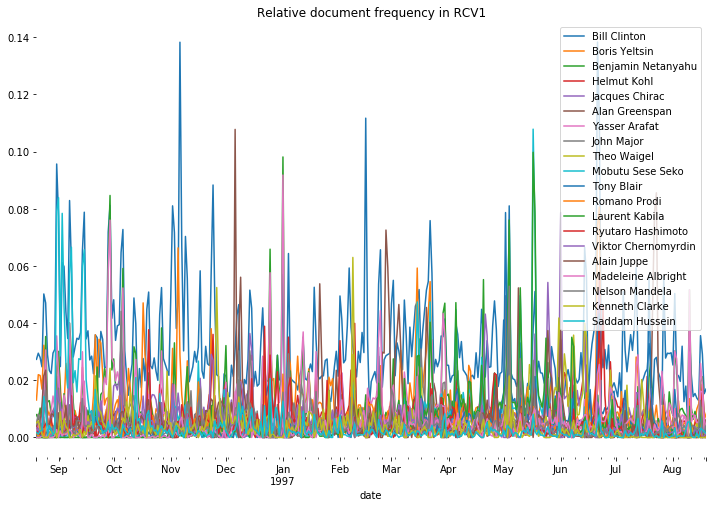

In [23]:
fig = by_day.plot.line(title='Relative document frequency in RCV1', figsize=(12,8))

The problem is that we're trying to cram too much information (name, rank, frequency, date) into a tight space. Edward Tufte advocates the use of what he calls *small multiples* for presenting data like this:

>Small Multiples are small, thumbnail-sized representations of multiple images displayed all at once, which allows the reader to immediately, and in parallel, compare the inter-frame differences.

>Illustrations of postage-stamp size are indexed by category or a label, sequenced over time like the frames of a movie, or ordered by a quantitative variable not used in the single image itself.

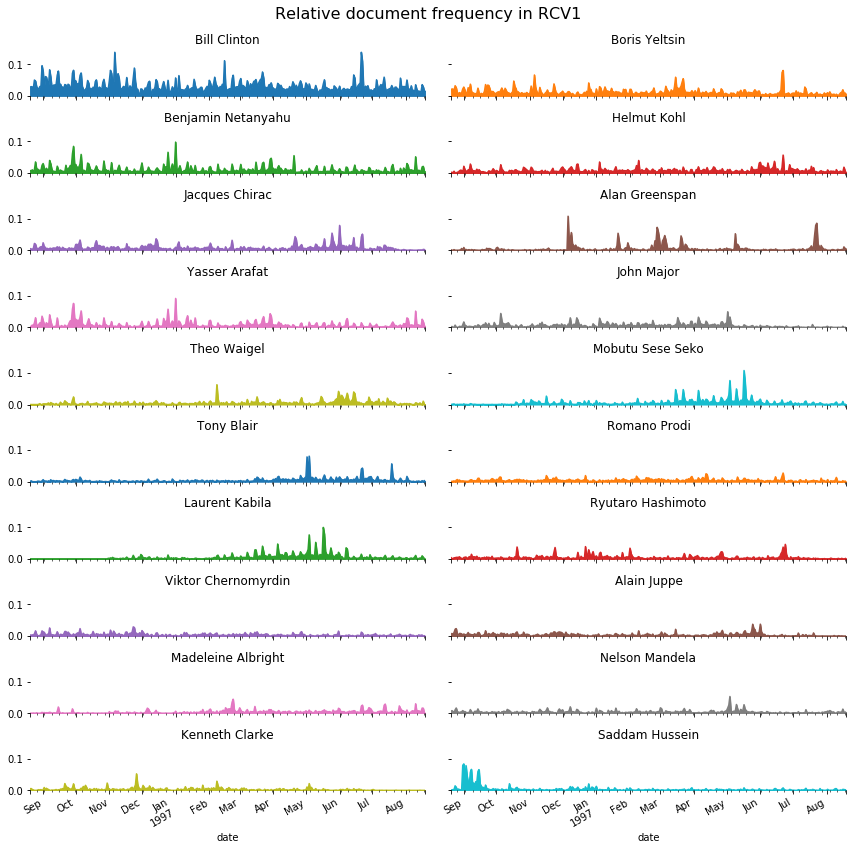

In [24]:
fig = by_day.plot.area(subplots=True,
                       layout=(10,2),
                       sharex=True,
                       sharey=True,
                       legend=False,
                       figsize=(12,12),
                       title=list(by_day.columns))
plt.suptitle('Relative document frequency in RCV1', size=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)

Now we're getting somewhere!  

There's still a problem though.  We're plotting relative document frequency *per day*, which can vary a lot for irrelevant external reasons.  The result is a very spiky plot that obscures longer-term trends.  

One solution is to smooth out the frequencies using a moving average:

In [25]:
by_day = by_day.rolling(window='7d').mean()

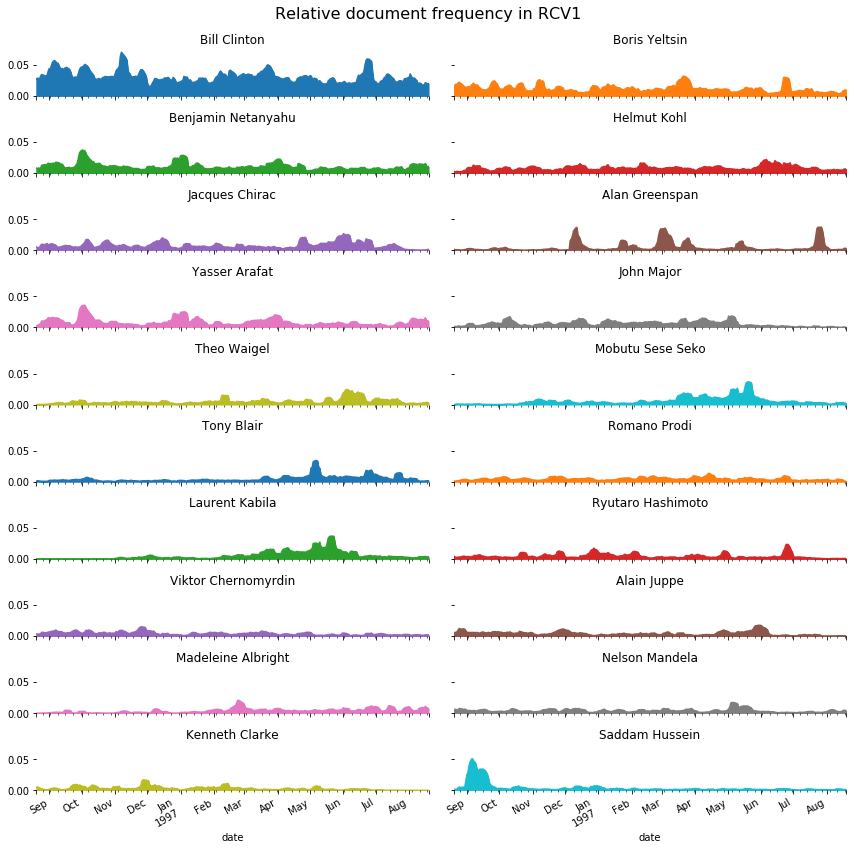

In [26]:
fig = by_day.plot.area(subplots=True,
                       layout=(10,2),
                       sharex=True,
                       sharey=True,
                       legend=False,
                       figsize=(12,12),
                       title=list(by_day.columns))
plt.suptitle('Relative document frequency in RCV1', size=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)

### Interactive visualization with bokeh

In [27]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.palettes import Category20
from bokeh.models import HoverTool, Legend
output_notebook()

Loading BokehJS ...

In [28]:
p = figure(title='Relative document frequency in RCV1',
           width=1000, height=600, 
           x_axis_type='datetime',
           toolbar_location='above')

L = [p.line(by_day.index, 
            by_day[n], 
            line_width=2,
            color=c, 
            alpha=0.75, 
            visible=False)
     for n, c in zip(by_day.columns, Category20[20])]
L[0].visible = True

legend = Legend(items=[(a,[b]) for a,b in zip(by_day.columns, L)], 
                location=(10,0), 
                click_policy='hide')
p.add_layout(legend, 'right')

hover = HoverTool(tooltips=[('date','$x{%F}')], formatters={'$x':'datetime'}, mode='mouse')
p.add_tools(hover)

In [29]:
show(p, notebook_handle=True)

In [30]:
from bokeh.resources import CDN
from bokeh.embed import file_html
html = file_html(p, CDN, 'rcv1')
with open('rcv1.html', 'w') as f:
    print(html, file=f)